In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [12]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [13]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

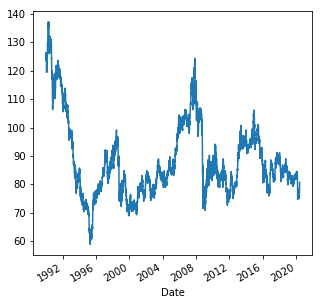

In [14]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(5,5))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Cyclical Downtrend

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [15]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
noise, trend = sm.tsa.filters.hpfilter(cad_jpy_df.Price)

In [16]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
price = pd.DataFrame()
price= cad_jpy_df[["Price"]].copy()
price["trend"]=trend
price["noise"]=noise
price.head()

,Price,trend,noise
Date,,,
1990-01-02,126.37,125.850905,0.519095
1990-01-03,125.30,125.679684,-0.379684
1990-01-04,123.46,125.508788,-2.048788
1990-01-05,124.54,125.338304,-0.798304
1990-01-08,124.27,125.167037,-0.897037


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc09c1d52d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc09c1d52d0>)

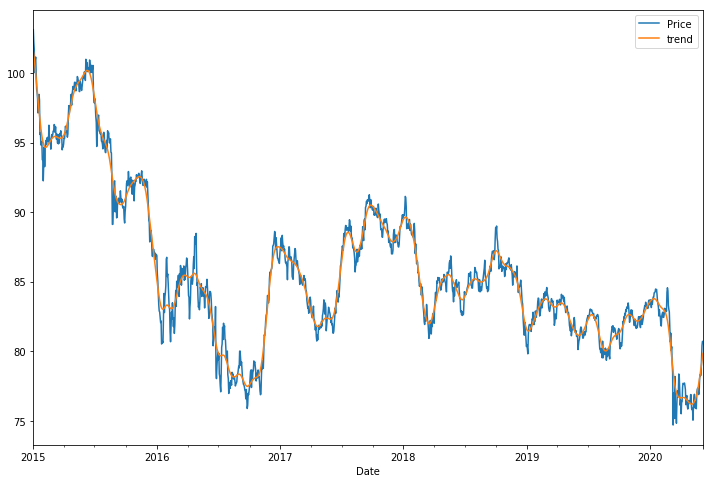

In [17]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
price.Price["2015":].plot(legend=True), price.trend["2015":].plot(figsize=(12,8), legend=True)

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Noise and Trend are strongly and negatively correlated, there is a clear long-term downtrend

In [18]:
# Plot the Settle Noise
price["noise"].plot

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [19]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [20]:
# Imports
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

In [21]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
armodel = ARMA(returns.Price.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = armodel.fit()

In [22]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Mon, 18 Oct 2021   AIC                          19513.955
Time:                        02:09:38   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1702           +0.0000j           42.1702            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

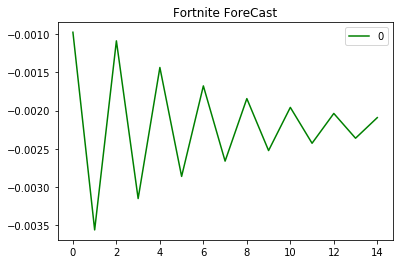

In [23]:
# Plot the 14 Day Returns Forecast
pd.DataFrame(results.forecast(steps=15)[0]).plot(title="Fortnite ForeCast", color = 'green')

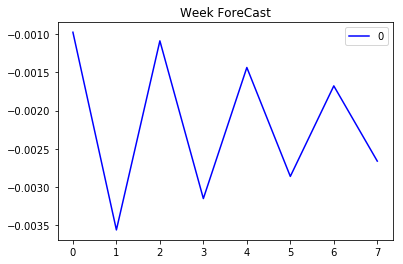

In [24]:
# Plot the 7 Day Returns Forecast
pd.DataFrame(results.forecast(steps=8)[0]).plot(title="Week ForeCast", color = 'Blue')

**Question:** Based on the p-value, is the model a good fit?

**Answer:** YOUR ANSWER HERE

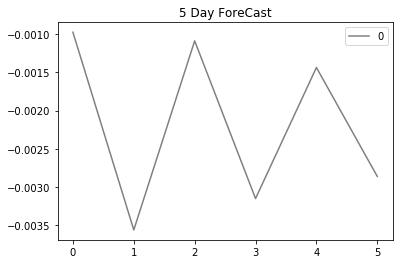

In [25]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=6)[0]).plot(title="5 Day ForeCast", color = 'Grey')

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [26]:
# Imports
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

In [27]:
# Estimate and ARIMA Model:
Arimodel = ARIMA(cad_jpy_df['Price'], order=(5,1,1))
# Fit the model
output = Arimodel.fit()

In [28]:
# Output model summary results:
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Mon, 18 Oct 2021   AIC                          17507.244
Time:                        02:09:40   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

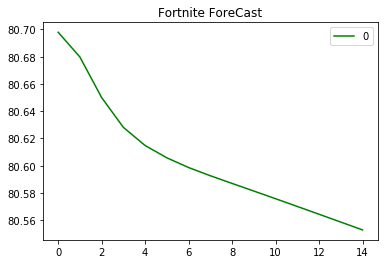

In [29]:
# Plot the 14 Day Returns Forecast
pd.DataFrame(output.forecast(steps=15)[0]).plot(title="Fortnite ForeCast", color = 'green')

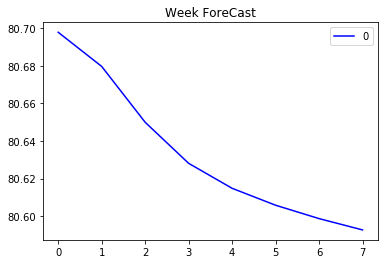

In [30]:
# Plot the 7 Day Returns Forecast
pd.DataFrame(output.forecast(steps=8)[0]).plot(title="Week ForeCast", color = 'Blue')

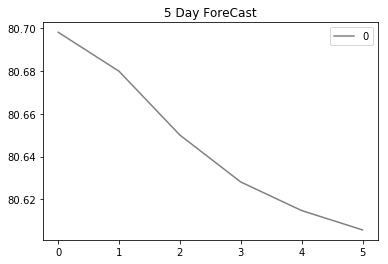

In [31]:
# Plot the 5 Day Price Forecast
pd.DataFrame(output.forecast(steps=6)[0]).plot(title="5 Day ForeCast", color = 'Grey')

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** YOUR ANSWER HERE

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [32]:
from arch import arch_model

ModuleNotFoundError: No module named 'arch'

In [ ]:
! ls -alsF

In [ ]:
! pwd

In [ ]:
# Estimate a GARCH model:
garch = arch.arch_model(returns, mean="Zero", vol="GARCH", p=6, q=3)

# Fit the model
fitted = model.fit(disp="off")

In [ ]:
# Summarize the model results
fitted.summary()

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [33]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = fitted.forecast(start=last_day, horizon=forecast_horizon)
forecasts

NameError: name 'fitted' is not defined

In [34]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

NameError: name 'forecasts' is not defined

In [35]:
# Transpose the forecast so that it is easier to plot
tp = intermediate.dropna().T
tp.head()

NameError: name 'intermediate' is not defined

In [36]:
# Plot the final forecast
tp.plot()

NameError: name 'tp' is not defined

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * Volatility is increasing and there is an overall downtrend, so no I would not. 

2. Is the risk of the yen expected to increase or decrease?
    * Based on long-term trends i think it is unlikely to recover, although it could be a good chance to buy now and see if their economy recovers faster than ours. 

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * I have no experience with these models, but i would be willing to play with an amount I Could lose. 

## Issues and Trouble Shooting
#### Unresolved Arch Issue